In [12]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Example audio file
audio_file = "../raw_data/lai4_FV2_MP3.mp3"

# Load audio data 
audio, sr = librosa.load(audio_file, sr=None)

# Play sound 
import IPython.display as ipd  
ipd.Audio(audio_file)

In [74]:
def get_mp3_info(y,sr):

    # Get sampling rate
    sampling_rate = sr

    # Get frames
    total_samples = len(y)

    # Get duration
    duration = librosa.get_duration(y=y, sr=sr)

    return {
        "Sampling Rate (Hz)": sampling_rate,
        "Frames": total_samples,
        "Duration (seconds)": duration
    }

info = get_mp3_info(audio,sr)
print("MP3 File Information:")
for key, value in info.items():
    print(f"{key}: {value}")

MP3 File Information:
Sampling Rate (Hz): 44100
Frames: 27695
Duration (seconds): 0.6280045351473923


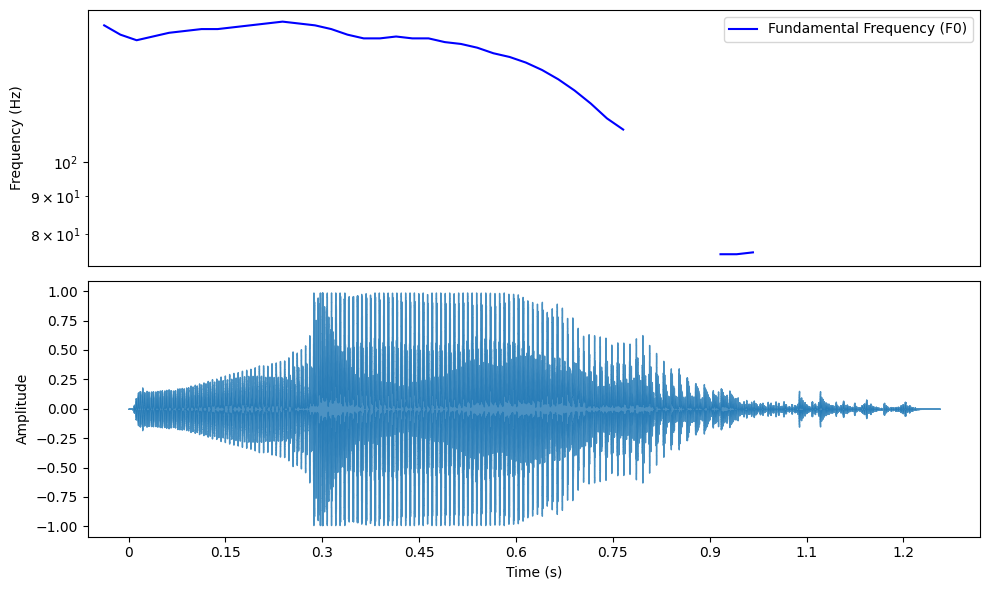

In [13]:
# Calculate pitch using fundamental frequency (f0)
f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# Plot pitch
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.semilogy(f0, label='Fundamental Frequency (F0)', color='b')
plt.ylabel('Frequency (Hz)')
plt.xticks([])
plt.xlim([0, len(f0)])
plt.legend(loc='upper right')

# Display waveform
plt.subplot(2, 1, 2)
librosa.display.waveshow(audio, alpha=0.8)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

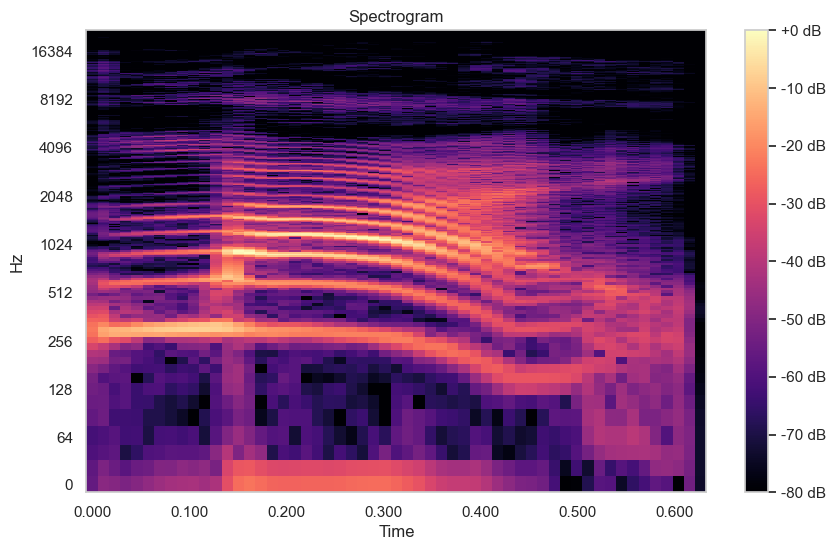

In [90]:
def get_spectrum(audio):

    # Compute STFT
    D = librosa.stft(audio)

    # Compute magnitude
    magnitude = np.abs(D)

    # Convert to dB
    log_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)

    # Plot spectrum
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_magnitude, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

def save_spectrum(audio, output_file=None):

    # Compute STFT
    D = librosa.stft(audio)

    # Compute magnitude
    magnitude = np.abs(D)

    # Convert to dB
    log_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)

    # Plot spectrum
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_magnitude, sr=sr, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.ylim([32, 8192])

    if output_file: plt.savefig(output_file, bbox_inches='tight', pad_inches=0, transparent=True)
    else: plt.show()    

    plt.close()

get_spectrum(audio=audio)
save_spectrum(audio=audio,output_file="spectrum.png")


## Prepare data 

In [117]:
import os
import csv
import re

# Create a list to store the extracted data
data = []

# Loop through the files in the directory
directory = '../raw_data/'
maxFiles = -1

for filename in os.listdir(directory):
    if filename.endswith('.mp3'):

        # Extract info from filename
        match = re.match(r'(\w+)(\d+)_(\w+)_MP3\.mp3', filename)
        if match:
            sound, tone, speaker = match.groups()

            audio, sr = librosa.load(directory+filename, sr=None)
            info = get_mp3_info(audio,sr)

            img_filename = f"spectrum_data/{sound}{tone}_{speaker}.png"
            save_spectrum(audio=audio,output_file=img_filename)
            
            data.append([filename, img_filename, sound, tone, speaker, info["Duration (seconds)"], info["Frames"], info["Sampling Rate (Hz)"] ])
        else:
            print(f"Error: No match found for filename '{filename}'")

        if maxFiles != -1 and len(data) >= maxFiles:
            break

# Write data to CSV
csv_file = 'output.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'img_filename', 'sound', 'tone', 'speaker', 'Duration (seconds)','Frames','Sampling Rate (Hz)'])
    writer.writerows(data)

print(f'CSV file "{csv_file}" has been created')


CSV file "output.csv" has been created


In [119]:
import pandas as pd
import seaborn as sns

train = pd.read_csv("output.csv")
num_entries = train.shape[0]
print(f'Number of entries in output.csv: {num_entries}')

Number of entries in output.csv: 9503


In [120]:
# Check csv file 
train.sample(10)
#train.head(10)

,filename,img_filename,sound,tone,speaker,Duration (seconds),Frames,Sampling Rate (Hz)
5880,bu4_FV1_MP3.mp3,spectrum_data/bu4_FV1.png,bu,4,FV1,0.601882,26543,44100
1757,shao2_MV3_MP3.mp3,spectrum_data/shao2_MV3.png,shao,2,MV3,0.549637,24239,44100
3189,quan2_FV1_MP3.mp3,spectrum_data/quan2_FV1.png,quan,2,FV1,0.941474,41519,44100
4520,me3_FV1_MP3.mp3,spectrum_data/me3_FV1.png,me,3,FV1,0.915351,40367,44100
1070,huang4_FV3_MP3.mp3,spectrum_data/huang4_FV3.png,huang,4,FV3,0.680249,29999,44100
6504,kou1_MV3_MP3.mp3,spectrum_data/kou1_MV3.png,kou,1,MV3,0.523515,23087,44100
8968,qiang2_MV1_MP3.mp3,spectrum_data/qiang2_MV1.png,qiang,2,MV1,0.680249,29999,44100
2610,liang2_FV1_MP3.mp3,spectrum_data/liang2_FV1.png,liang,2,FV1,0.915351,40367,44100
6501,ce4_FV2_MP3.mp3,spectrum_data/ce4_FV2.png,ce,4,FV2,0.732494,32303,44100
8410,dui4_FV3_MP3.mp3,spectrum_data/dui4_FV3.png,dui,4,FV3,0.523515,23087,44100


/var/folders/sy/mg_z9v4x0ms652tc0sx_gq6h0000gn/T/ipykernel_12139/4065568107.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=speaker_counts, x='tone', y='speaker', palette="viridis")


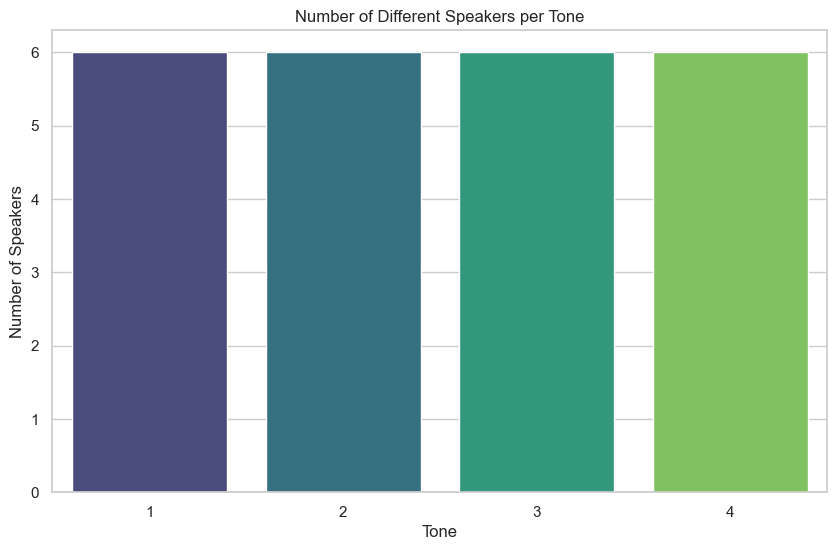

In [121]:
# Control plots
speaker_counts = train.groupby('tone')['speaker'].nunique().reset_index()
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(data=speaker_counts, x='tone', y='speaker', palette="viridis")
plt.title("Number of Different Speakers per Tone")
plt.xlabel("Tone")
plt.ylabel("Number of Speakers")
plt.show()

## ML 

In [122]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Extract file paths and tone labels
data = pd.read_csv('output.csv')
file_paths = data['img_filename']
tones = data['tone']

# Encode tone labels
label_encoder = LabelEncoder()
tones_encoded = label_encoder.fit_transform(tones)
num_classes = len(label_encoder.classes_)

print("File paths:")
print(file_paths)

print("\nTones encoded:")
print(tones_encoded)

print("\nNumber of classes:")
print(num_classes)

File paths:
0          spectrum_data/sa3_MV1.png
1         spectrum_data/cao2_FV1.png
2        spectrum_data/hong1_MV2.png
3       spectrum_data/zheng3_MV3.png
4        spectrum_data/shao4_MV1.png
                    ...             
9498     spectrum_data/zhan3_MV3.png
9499     spectrum_data/zhei3_FV2.png
9500     spectrum_data/peng4_FV1.png
9501    spectrum_data/chuan1_FV2.png
9502      spectrum_data/luo4_MV3.png
Name: img_filename, Length: 9503, dtype: object

Tones encoded:
[2 1 0 ... 3 0 3]

Number of classes:
4


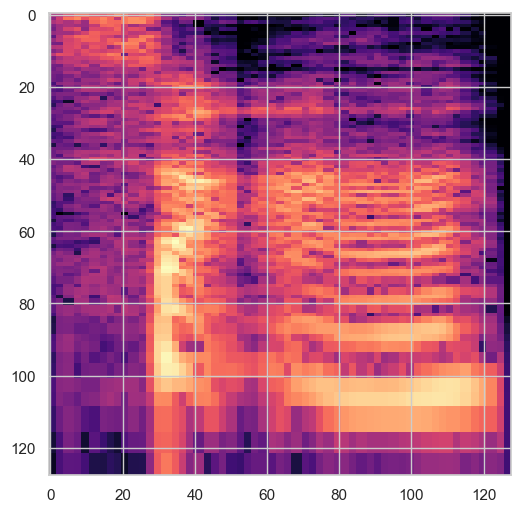

In [141]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(file_paths, tones_encoded, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Scale pixel values to the [0, 1] range
    rotation_range=150,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #horizontal_flip=True
)

def load_and_preprocess_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    #img = datagen.random_transform(img)
    img = img / 255.0
    return img

# Test with sample image
sample_image = load_and_preprocess_image(file_paths[0])
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
#plt.axis('off')
plt.show()

In [128]:
# Load training images
X_train = np.array([load_and_preprocess_image(fp) for fp in X_train])
X_test = np.array([load_and_preprocess_image(fp) for fp in X_test])

In [129]:
# Define model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Train model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
238/238 [==============================] - 26s 109ms/step - loss: 0.1800 - accuracy: 0.9378 - val_loss: 0.0617 - val_accuracy: 0.9863
Epoch 2/10
238/238 [==============================] - 25s 107ms/step - loss: 0.0221 - accuracy: 0.9953 - val_loss: 0.0358 - val_accuracy: 0.9932
Epoch 3/10
238/238 [==============================] - 25s 106ms/step - loss: 0.0132 - accuracy: 0.9984 - val_loss: 0.0223 - val_accuracy: 0.9942
Epoch 4/10
238/238 [==============================] - 26s 108ms/step - loss: 0.0119 - accuracy: 0.9967 - val_loss: 0.0413 - val_accuracy: 0.9926
Epoch 5/10
238/238 [==============================] - 26s 109ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.0194 - val_accuracy: 0.9958
Epoch 6/10
238/238 [==============================] - 26s 109ms/step - loss: 0.0072 - accuracy: 0.9972 - val_loss: 0.1003 - val_accuracy: 0.9821
Epoch 7/10
238/238 [==============================] - 25s 107ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.0245 - val_ac

In [130]:
# Print performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

60/60 [==============================] - 2s 28ms/step - loss: 0.0232 - accuracy: 0.9979
Test Loss: 0.0232, Test Accuracy: 0.9979


In [139]:
# Predict for example file
example_image_file = 'spectrum_data/ao4_MV3.png'  
example_image = load_and_preprocess_image(example_image_file)
predictions = model.predict(np.expand_dims(example_image, axis=0))

# Get probabilities
label_probabilities = predictions[0]
class_names = [ '1', '2', '3', '4']  
label_probabilities_dict = {class_names[i]: label_probabilities[i] for i in range(len(class_names))}
predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])[0]
print(f"Predicted Class: {predicted_class}")

# Print probabilities
for class_name, probability in label_probabilities_dict.items():
    print(f"Class: {class_name}, Probability: {probability:.4f}")


1/1 [==============================] - 0s 16ms/step
Predicted Class: 3
Class: 1, Probability: 0.0000
Class: 2, Probability: 0.0003
Class: 3, Probability: 0.8868
Class: 4, Probability: 0.1129


In [140]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test set
predicted_probabilities = model.predict(X_test)
true_labels = y_test

# Compute ROC curve and AUC for each class 
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)  
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


ValueError: in user code:

    File "/Users/pdargent/miniconda3/envs/chineseTones_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/pdargent/miniconda3/envs/chineseTones_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/pdargent/miniconda3/envs/chineseTones_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/pdargent/miniconda3/envs/chineseTones_env/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/pdargent/miniconda3/envs/chineseTones_env/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/pdargent/miniconda3/envs/chineseTones_env/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "conv2d_2" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=False
      • mask=None
